# TF-IDF
Pensamos en utilizar TF-IDF porque este método permite recuperar palabras clave a través de varios documentos, no sólo en uno como lo hace RAKE, además nosotros tomaremos como documentos cada oración que se dice en un lapso de tiempo según los subtítulos de Youtube y para recuperar los documentos verificaremos que todas las palabras dadas en la query estén también en él, asignandolé un score dado por TF-IDF y regresando el top 10.

In [ ]:
from os import listdir
from os.path import isfile, join
import json
# nltk
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords #Listas de stopwords
from nltk.tokenize import word_tokenize#Tokens
import re #regex
import pickle
from tqdm import tqdm 
from collections import defaultdict, Counter
import pandas as pd
from operator import itemgetter
import numpy as np
#Para graficar palabras
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

Cargamos el corpus limpio

In [26]:
with open("../pkl/clean_videos.pkl", "rb") as f:
    videos = pickle.load(f)
videos[0][0]

{'id': 'L9YhoRatRzE',
 'original_title': 'Siempre Fui Yo | Adelanto | Disney+',
 'subtitles': [{'start': '0.13',
   'dur': '3.77',
   'text': ['tu', 'papá', 'tuvo', 'un', 'accidente']},
  {'start': '12.5', 'dur': '5.939', 'text': ['te', 'recuerdo', 'que', 'está']},
  {'start': '15.59', 'dur': '5.339', 'text': ['aquí']},
  {'start': '18.439',
   'dur': '6.361',
   'text': ['estaba', 'como', 'rabioso', 'con']},
  {'start': '20.929',
   'dur': '7.65',
   'text': ['especial', 'con', 'lucas', 'martín']},
  {'start': '24.8',
   'dur': '3.779',
   'text': ['necesito', 'saber', 'qué', 'fue', 'lo', 'que', 'pasó']},
  {'start': '29.42', 'dur': '2.479', 'text': ['aplausos']}]}

Juntamos todas las oraciones para calcular TF-IDF

In [71]:
documents = defaultdict(list)
def merge_videos(corpus):
    '''
    Mezcla los subtítulos de cada video en una entrada del
    diccionario (id, sub), 
    Guarda los diálogos por línea tokenizados y limpios

    Args:
        col (dic): Diccionario con los diálogos
    '''
    corpus_clean = []
    #Iteramos sobre los canales
    for chanel in tqdm(corpus):
        for video in chanel:
            #Cada texto se guarda por oraciones
            if 'subtitles' in video:
                corpus_clean += [s['text'] for s in video['subtitles']]
                for s in video['subtitles']:
                    documents[video['id']] += s["text"]
    return corpus_clean

all_videos = merge_videos(videos)
all_videos[0]

100%|██████████| 9/9 [00:00<00:00, 15.82it/s]


['tu', 'papá', 'tuvo', 'un', 'accidente']

In [72]:
def flatten(lst):
    '''
    Junta las listas anidadas en una 

    Args:
        lst (list): Lista de listas
    '''
    return [item for sub in lst for item in sub]

Obtenemos las frecuencias de cada palabra en todo el corpus

In [73]:
term_frequencies = Counter(flatten(all_videos))

In [25]:
term_list = pd.DataFrame(sorted(term_frequencies.items(), key=itemgetter(1), reverse=True), 
                         columns=['Token','Frequency'])

term_list = term_list.set_index(term_list['Token'])
term_list.pop('Token')
term_list

,Frequency
Token,
de,217897
que,167644
la,128609
y,116389
el,105011
...,...
nananana,1
nía,1
llull,1


Calculamos el IDF de cada termino dentro de los documentos (todos los subtítulos de cada vídeo)

In [ ]:
idf = {}
num_documents = len(documents)
for term in tqdm(term_list.index):
    #Total de documentos en que
    #aparece el término
    total_documents = 0
    for doc, token_list in documents.items():
        if term in token_list:
            total_documents += 1
            
    #Asignación de idf
    idf[term] = -np.log2(total_documents/num_documents)

#Agregamos el idf al dataframe
term_list['idf'] = idf.values()
term_list = term_list.sort_values(by='idf', ascending=False)
#Lo guardamos
pickle.dump(term_list, open("../pkl/term_list.pkl", "wb"))

In [5]:
documents["L9YhoRatRzE"]

['tu',
 'papá',
 'tuvo',
 'un',
 'accidente',
 'te',
 'recuerdo',
 'que',
 'está',
 'aquí',
 'estaba',
 'como',
 'rabioso',
 'con',
 'especial',
 'con',
 'lucas',
 'martín',
 'necesito',
 'saber',
 'qué',
 'fue',
 'lo',
 'que',
 'pasó',
 'aplausos']

In [6]:
with open("../pkl/term_list.pkl", "rb") as f:
    term_list = pickle.load(f)

term_list = term_list.sort_values(by='idf', ascending=False)
term_list[100:130]

,Frequency,idf
Token,,
blass,5,11.67904
neocelandés,1,11.67904
juventudes,1,11.67904
jarryd,1,11.67904
première,1,11.67904
yesin,1,11.67904
fosis,1,11.67904
identifique,1,11.67904
contemplaban,1,11.67904


Nuestros documentos serán oraciones

In [ ]:
#Parametro
a = 0.5

#Guarda los tfidf
tfidf = {}
for doc, token_list in documents.items():
    try:
        #Cuenta la frecuencia del término en el documento
        term_freq_doc = Counter(token_list)
        #print(term_freq_doc.values())
        #Obtiene la frecuencia mayor
        max_freq = np.max(list(term_freq_doc.values()))
        #Guarda tfidf por documento
        tfidf_doc = {}
        for term in term_freq_doc:
            #Valor de TF
            tf = a + (1-a)*(term_list["Frequency"][term]/max_freq)
            #Valor de tfidf
            tfidf_doc[term] = tf*term_list["idf"][term]
            
        tfidf[doc] = tfidf_doc
    except:
        print(doc,token_list)

In [ ]:
pickle.dump(tfidf, open("../pkl/tfidf.pkl", "wb"))

In [5]:
with open("../pkl/tfidf.pkl", "rb") as f:
    tfidf = pickle.load(f)

tfidf["L9YhoRatRzE"]

{'tu': 1418.7040158067475,
 'papá': 413.2296042991872,
 'tuvo': 433.0538386324496,
 'un': 1977.6454572285645,
 'accidente': 178.37919007682308,
 'te': 1675.3258637158917,
 'recuerdo': 306.48387045316315,
 'que': 2754.05210974035,
 'está': 1444.7053994278488,
 'aquí': 1349.9768500097691,
 'estaba': 996.2010785976058,
 'como': 2163.693302579083,
 'rabioso': 16.37494616013497,
 'con': 1854.840635821252,
 'especial': 503.554450076275,
 'lucas': 23.400066758614557,
 'martín': 80.14848223671673,
 'necesito': 322.01821137768957,
 'saber': 592.050234798179,
 'qué': 1366.1480148444505,
 'fue': 1524.2868763932865,
 'lo': 1667.7345204412673,
 'pasó': 526.0974232026272,
 'aplausos': 771.3768033282756}

## Vectores TF-IDF

Obtenemos el tamaño de oración más larga en el corpus

In [27]:
def get_max():
    '''
    Obtiene el tamaño de la oración más larga en el corpus
    '''
    max = 0
    for chanel in tqdm(videos):
        for video in chanel:
            #Cada texto se guarda por oraciones
            if 'subtitles' in video:
                for s in video['subtitles']: 
                        max = len(s["text"]) if len(s["text"]) > max else max
    return max

Hacemos todos los vectores del mismo tamaño

In [28]:
def do_padding(vector, t):
    '''
    Agrega 0 al vector si no es del tamaño t 

    Args:
        vector (lst): lista de tamaño diferente
        t (int): Tamaño esperado del vector
    '''
    for i in range(0, t - len(vector)):
        vector.append(0)

In [53]:
def get_tfid_vectors(tfidf, corpus_tfidf):
    '''
    Por cada palabra de cada subtítulo se 
    busca su valor tfidf y se crea un vector con esos valores

    Args:
        tfid (dic): diccionario de palabras por vídeo
        corpus_tfidf (json): corpus a modificar
    '''
    max = get_max()
    print("Longitud de la oración más larga: ",max)
    #Iteramos sobre los canales
    for chanel in tqdm(corpus_tfidf):
        for video in chanel:
            #Cada texto se guarda por oraciones
            if 'subtitles' in video:
                for s in video['subtitles']:
                    vector = []
                    for t in s["text"]:
                        vector.append(tfidf[video['id']][t])
                    do_padding(vector, max)
                    s["tfid"] = vector

Obtenemos los vectores

In [54]:
get_tfid_vectors(tfidf, videos)
videos[0][0]

100%|██████████| 9/9 [00:00<00:00, 48.15it/s]


Longitud de la oración más larga:  56


100%|██████████| 9/9 [00:05<00:00,  1.58it/s]


{'id': 'L9YhoRatRzE',
 'original_title': 'Siempre Fui Yo | Adelanto | Disney+',
 'subtitles': [{'start': '0.13',
   'dur': '3.77',
   'text': ['tu', 'papá', 'tuvo', 'un', 'accidente'],
   'tfid': [1418.7040158067475,
    413.2296042991872,
    433.0538386324496,
    1977.6454572285645,
    178.37919007682308,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0]},
  {'start': '12.5',
   'dur': '5.939',
   'text': ['te', 'recuerdo', 'que', 'está'],
   'tfid': [1675.3258637158917,
    306.48387045316315,
    2754.05210974035,
    1444.7053994278488,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
   

Gráficamos los vectores de TF-IDF de cada oración 

In [55]:
def get_vectors():
    '''
    Regresa un diccionario con los subtítulos y su vector tfidf
    '''
    vectors = {}
    #Iteramos sobre los canales
    for chanel in tqdm(videos):
        for video in chanel:
            #Cada texto se guarda por oraciones
            if 'subtitles' in video:
                for s in video['subtitles']:
                    vectors[" ".join(s["text"])] = s["tfid"]
    return vectors

100%|██████████| 9/9 [00:00<00:00, 12.85it/s]
10it [00:00, 5510.84it/s]


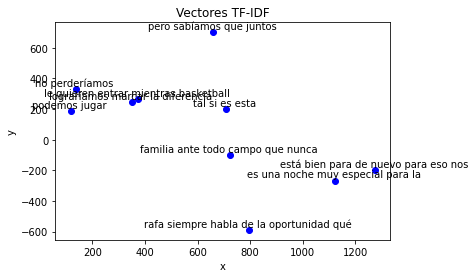

In [56]:
#Función para plotear en dos dimensiones con etiquetas
def plot_words(X,ids):
    '''
    Gráfica las oraciones dado su vector tfid

    Args:
        X (list): coordenadas del vector aplicando PCA
        ids (list): oraciones
    '''
    r=0
    plt.scatter(X[:,0],X[:,1], marker='o', c='blue')
    for label,x,y in tqdm(zip(ids, X[:,0], X[:,1])):
        plt.annotate(label, xy=(x,y), xytext=(-1,1), textcoords='offset points', ha='center', va='bottom')
        r+=1
        
mds_model = PCA(n_components=2)
vectors = get_vectors()
X_pca = mds_model.fit_transform(list(vectors.values()))
#Solo se gráfican algunas oraciones
plot_words(X_pca[10:20], list(vectors.keys())[10:20])
plt.title('Vectores TF-IDF')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## Recuperación de Documentos con TFIDF

In [36]:
# tokens que necesitan ser limpiados del corpus y que no
# se encuentran en la lista de stopwords
more = ["si", "bien", "ahora", "así", "aquí", "pues"]
stopwords_list = stopwords.words('spanish') + more

def get_tokens_clean(text, stop_words=True):
    '''
    Genera los tokens de una cadena y los limpia
    (quita símbolos raros y stopwords)
    
    Args:
        text (str): cadena
    '''
    tokens = word_tokenize(text)
    clean = []
    pattern = r'[-_{}(),;:"#\/.¡!¿?·\[\]\'`]'
    for w in tokens:
        #quita stopwords y convierte a minúsculas
        w = re.sub(pattern,'', w.lower())
        if w != '':
            clean.append(w)
    return clean

Obtenemos los tados originales para regresar la cadena

In [40]:
def get_txt(path):
    """
    Regresa una lista con el contenido de todos los archivos de un directorio

    Args:
        path (str): ruta de la carpeta
    """
    text = []
    onlyfiles = [f for f in listdir(path) if isfile(join(path, f))]
    
    for file in onlyfiles:
        with open(path+"/"+file, 'rb') as f:
            text.append(json.loads(f.read().decode('utf-8', 'replace')))
    return text

# Guardamos los subtitulos de todos los canales
videos_original = get_txt("../corpus/data")#Nota: no print de todo

In [59]:
def recover_documents(query):
    """
    Función para recuperar documentos en base a su valor de TFIDF.
    
    Arguments
    ---------
    query : str
        Cadena a buscar
    tfidf_weights : dict
        Diccionario de tfidf por documentos y términos
    """
    #Obtener términos en query y procesarlos
    proc_query = flatten([get_tokens_clean(w) for w in query.split()])
    print(proc_query)
    #Iteramos sobre los canales
    for chanel in tqdm(videos):
        for video in chanel:
            #Cada texto se guarda por oraciones
            if 'subtitles' in video:
                for i,s in enumerate(video['subtitles']):
                    score = 0
                    for w in proc_query:
                        #Revisa si todos los terminos de la query están en el documento
                        if w in s["text"]:
                            index = s["text"].index(w)
                            score += s["tfid"][index]
                        else:
                            score = 0
                            break
                    yield (video['id'], i), score

In [65]:
def get_original(id, index_sub):
    '''
    Regresa el texto original

    Args:
        id (str): id del vídeo
        index_sub (int): índice del subtítulo del vídeo
    '''
    for chanel in videos_original:
        for video in chanel:
            if video['id'] == id:
                if 'subtitles' in video:
                    return video['subtitles'][index_sub]

In [75]:
#Consulta
query = 'estoy triste'
#Resultados de la consulta
results = recover_documents(query)
#Ordena la consulta de mayor peso a menor
sorted_results = sorted(results, key=itemgetter(1), reverse=True)[:10]
print(len(sorted_results))
for doc, score in sorted_results:
    print('Id: {} \nInfo: {}\n score: {}\n ---------'.format(doc[0],get_original(doc[0], doc[1]), score))

['estoy', 'triste']


100%|██████████| 9/9 [00:00<00:00, 11.28it/s]

10
Info: {'start': '91.966', 'dur': '3.379', 'text': 'Cuando te sientas triste,\nrecuerda que estoy contigo.'}
 score: 504.7442363778428
 ---------
Info: {'start': '121.621', 'dur': '4.338', 'text': 'Pero como seguidor de hace tanto tiempo,\nestoy un poco triste.'}
 score: 230.94124579530845
 ---------
Info: {'start': '160.22', 'dur': '4.64', 'text': 'estoy triste porque mi hermano me odia'}
 score: 230.94124579530845
 ---------
Info: {'start': '36.29', 'dur': '6.29', 'text': 'si estoy triste toma aire estoy feliz'}
 score: 122.28926540541389
 ---------
Info: {'start': '339.006', 'dur': '3.628', 'text': '- Creo que escribiste más que yo.\n- Estoy muy triste por no haber logrado los 26.'}
 score: 47.59102888736138
 ---------
Info: {'start': '384.76', 'dur': '4.671', 'text': 'Estoy muy triste. Vi la A durante un segundo y no se me ocurrió nada.'}
 score: 47.59102888736138
 ---------
Info: {'start': '221.554', 'dur': '2.369', 'text': '¿Por qué? No estoy triste. Iba a morir.'}
 score: 45.3